Conformal Prediction for Classification

https://arxiv.org/pdf/2107.07511

In [2]:
#%%
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as graph


ALPHA = 0.001  # error rate
print(f'Ensured accuracy: {1 - ALPHA:.2%}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

n_train = int(len(train_dataset) * 0.80)
calibration_size = len(train_dataset) - n_train


# Ensures exchangeability of train and calibration sets
train_dataset, calibration_dataset = random_split(train_dataset, [n_train, calibration_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
calibration_loader = DataLoader(calibration_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


#################################################################################################
# Define the CNN model
#################################################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 28x28x1 -> 28x28x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 28x28x16 -> 28x28x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # 28x28x32 -> 28x28x64

        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.LazyLinear(10)

        self.pool = nn.MaxPool2d(2, 2)  # 28x28x64 -> 14x14x64

    def forward(self, x, temperature=1.0):
        # Convolutional layers
        x = F.gelu(self.conv1(x))  # 28x28x1 -> 28x28x16
        x = self.pool(F.gelu(self.conv2(x)))  # 28x28x16 -> 14x14x32
        x = self.pool(F.gelu(self.conv3(x)))  # 14x14x32 -> 7x7x64

        # Fully connected layers
        x = torch.flatten(x, 1)
        x = F.gelu(self.fc1(x))  # 3136 -> 512
        x = self.fc2(x)  # 512 -> 10
        if temperature != 1.0:
            x /= temperature
        return x  # Return logits, not softmax probabilities

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#################################################################################################
# Train the model
#################################################################################################
model.train()
for epoch in trange(10, desc='Training'):
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

#################################################################################################
# Evaluate test accuracy
#################################################################################################
model.eval()
correct, total = 0, 0
with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f'Test Accuracy: {correct / total:.2%}')

#################################################################################################
# Calibration
#################################################################################################
# For conformal prediction, we need to compute nonconformity scores
# A common choice is to use 1 - p_y where p_y is the probability of the true class
calibration_scores = []

with torch.inference_mode():
    for batch_idx, (x, y) in enumerate(calibration_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)

        # Extract the predicted probability of the true class for each sample in the batch
        true_class_probs = probs.gather(1, y.view(-1, 1))
        scores = 1 - true_class_probs
        calibration_scores.append(scores)

calibration_scores = torch.cat(calibration_scores)
calibration_scores = calibration_scores.cpu().numpy()

# Compute the calibration threshold
# We use the (1-alpha) quantile of the calibration scores
n_calibration = len(calibration_scores)
calibration_threshold = np.quantile(calibration_scores, 1-ALPHA)
print(f"Calibration threshold: {calibration_threshold:.4f}")


Ensured accuracy: 99.90%


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy: 98.86%
Calibration threshold: 0.9998


# Present the Inductive Conformal Prediction on the test set

  0%|          | 0/10000 [00:00<?, ?it/s]

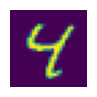

Prediction set: [4, 8] | True class: 4
------------------------------


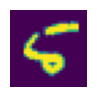

Prediction set: [5, 8] | True class: 5
------------------------------


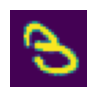

Prediction set: [0, 2, 3, 5, 8, 9] | True class: 3
------------------------------


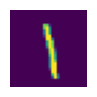

Prediction set: [1, 7] | True class: 1
------------------------------


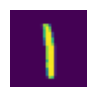

Prediction set: [1, 7] | True class: 1
------------------------------


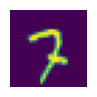

Prediction set: [3, 7] | True class: 7
------------------------------


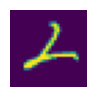

Prediction set: [2, 4] | True class: 2
------------------------------


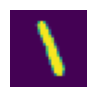

Prediction set: [1, 8] | True class: 1
------------------------------


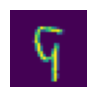

Prediction set: [5, 9] | True class: 9
------------------------------


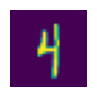

Prediction set: [4, 5, 9] | True class: 4
------------------------------


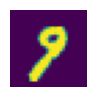

Prediction set: [8, 9] | True class: 9
------------------------------


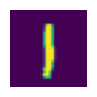

Prediction set: [1, 8] | True class: 1
------------------------------


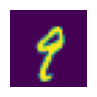

Prediction set: [8, 9] | True class: 9
------------------------------


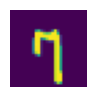

Prediction set: [7, 9] | True class: 7
------------------------------


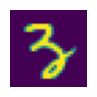

Prediction set: [3, 7] | True class: 3
------------------------------


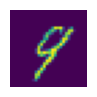

Prediction set: [8, 9] | True class: 9
------------------------------


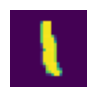

Prediction set: [1, 4] | True class: 1
------------------------------


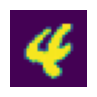

Prediction set: [4, 8] | True class: 4
------------------------------


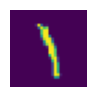

Prediction set: [1, 7] | True class: 1
------------------------------


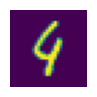

Prediction set: [4, 8, 9] | True class: 4
------------------------------


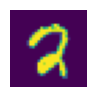

Prediction set: [2, 7, 8] | True class: 2
------------------------------


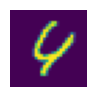

Prediction set: [4, 8, 9] | True class: 4
------------------------------


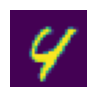

Prediction set: [4, 9] | True class: 4
------------------------------


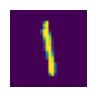

Prediction set: [1, 8] | True class: 1
------------------------------


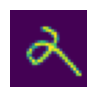

Prediction set: [2, 9] | True class: 2
------------------------------


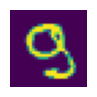

Prediction set: [8, 9] | True class: 9
------------------------------


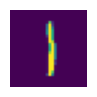

Prediction set: [1, 7] | True class: 1
------------------------------


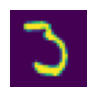

Prediction set: [2, 3] | True class: 3
------------------------------


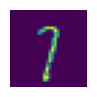

Prediction set: [1, 3, 7, 9] | True class: 7
------------------------------


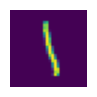

Prediction set: [1, 8] | True class: 1
------------------------------


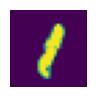

Prediction set: [1, 8] | True class: 1
------------------------------


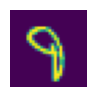

Prediction set: [8, 9] | True class: 9
------------------------------


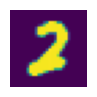

Prediction set: [2, 3] | True class: 2
------------------------------


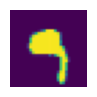

Prediction set: [4, 9] | True class: 9
------------------------------


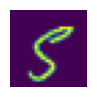

Prediction set: [5, 8] | True class: 5
------------------------------


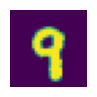

Prediction set: [8, 9] | True class: 9
------------------------------


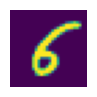

Prediction set: [6, 8] | True class: 6
------------------------------


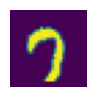

Prediction set: [7, 9] | True class: 7
------------------------------


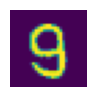

Prediction set: [5, 9] | True class: 9
------------------------------


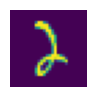

Prediction set: [2, 7] | True class: 2
------------------------------


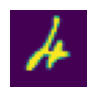

Prediction set: [1, 2, 4, 6, 8] | True class: 4
------------------------------


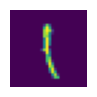

Prediction set: [1, 4, 8] | True class: 1
------------------------------


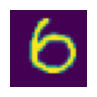

Prediction set: [0, 6] | True class: 6
------------------------------


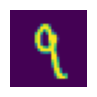

Prediction set: [8, 9] | True class: 9
------------------------------


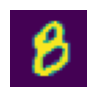

Prediction set: [0, 8] | True class: 8
------------------------------


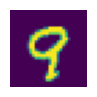

Prediction set: [8, 9] | True class: 9
------------------------------


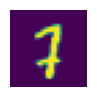

Prediction set: [3, 7] | True class: 7
------------------------------


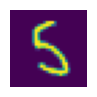

Prediction set: [5, 8] | True class: 5
------------------------------


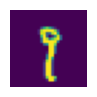

Prediction set: [8, 9] | True class: 9
------------------------------


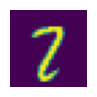

Prediction set: [2, 7] | True class: 2
------------------------------


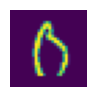

Prediction set: [0, 8] | True class: 0
------------------------------


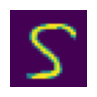

Prediction set: [5, 8] | True class: 5
------------------------------


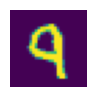

Prediction set: [8, 9] | True class: 9
------------------------------


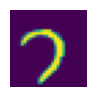

Prediction set: [3, 7, 9] | True class: 7
------------------------------


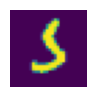

Prediction set: [3, 5] | True class: 5
------------------------------


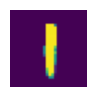

Prediction set: [1, 7] | True class: 1
------------------------------


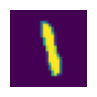

Prediction set: [1, 7, 8] | True class: 1
------------------------------


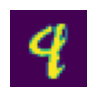

Prediction set: [4, 8, 9] | True class: 9
------------------------------


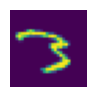

Prediction set: [3, 7] | True class: 3
------------------------------


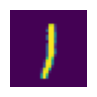

Prediction set: [1, 7] | True class: 1
------------------------------


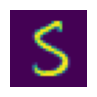

Prediction set: [5, 8] | True class: 5
------------------------------


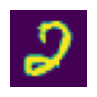

Prediction set: [2, 8] | True class: 2
------------------------------


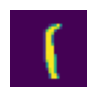

Prediction set: [1, 8] | True class: 1
------------------------------


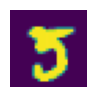

Prediction set: [3, 5] | True class: 5
------------------------------


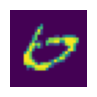

Prediction set: [0, 4, 5, 6] | True class: 6
------------------------------


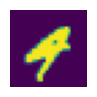

Prediction set: [4, 9] | True class: 4
------------------------------


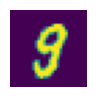

Prediction set: [8, 9] | True class: 9
------------------------------


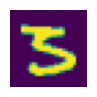

Prediction set: [3, 5] | True class: 3
------------------------------


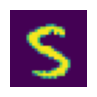

Prediction set: [5, 8] | True class: 5
------------------------------


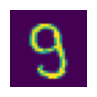

Prediction set: [8, 9] | True class: 9
------------------------------


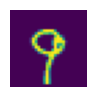

Prediction set: [8, 9] | True class: 9
------------------------------


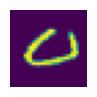

Prediction set: [0, 4] | True class: 0
------------------------------


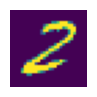

Prediction set: [2, 8] | True class: 2
------------------------------


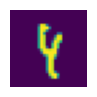

Prediction set: [4, 8, 9] | True class: 4
------------------------------


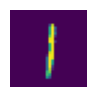

Prediction set: [1, 7] | True class: 1
------------------------------


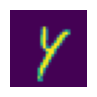

Prediction set: [4, 8] | True class: 4
------------------------------


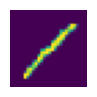

Prediction set: [1, 4, 8] | True class: 1
------------------------------


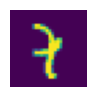

Prediction set: [2, 7] | True class: 7
------------------------------


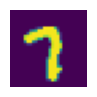

Prediction set: [2, 3, 7] | True class: 7
------------------------------


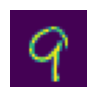

Prediction set: [8, 9] | True class: 9
------------------------------


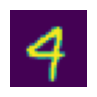

Prediction set: [4, 9] | True class: 4
------------------------------


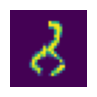

Prediction set: [2, 3, 8] | True class: 8
------------------------------


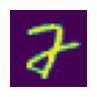

Prediction set: [2, 3, 7] | True class: 2
------------------------------


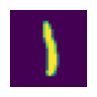

Prediction set: [1, 7] | True class: 1
------------------------------


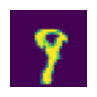

Prediction set: [8, 9] | True class: 9
------------------------------


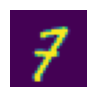

Prediction set: [3, 7] | True class: 7
------------------------------


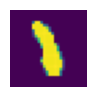

Prediction set: [0, 1, 2, 3, 6, 7, 8] | True class: 1
------------------------------


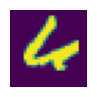

Prediction set: [4, 6] | True class: 6
------------------------------


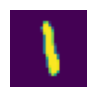

Prediction set: [1, 7, 8] | True class: 1
------------------------------


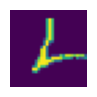

Prediction set: [2, 4] | True class: 2
------------------------------


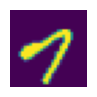

Prediction set: [7, 9] | True class: 7
------------------------------


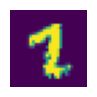

Prediction set: [0, 1, 2, 3, 7, 8] | True class: 2
------------------------------


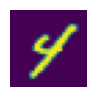

Prediction set: [4, 8] | True class: 4
------------------------------


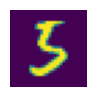

Prediction set: [3, 5] | True class: 5
------------------------------


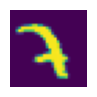

Prediction set: [2, 3, 7] | True class: 7
------------------------------


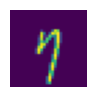

Prediction set: [7, 9] | True class: 7
------------------------------


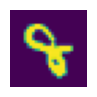

Prediction set: [7, 8] | True class: 8
------------------------------


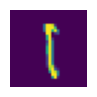

Prediction set: [1, 8] | True class: 1
------------------------------


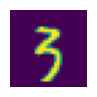

Prediction set: [3, 5] | True class: 3
------------------------------


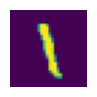

Prediction set: [1, 8] | True class: 1
------------------------------


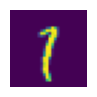

Prediction set: [1, 2, 7, 8, 9] | True class: 1
------------------------------


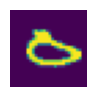

Prediction set: [0, 4, 5, 6] | True class: 0
------------------------------


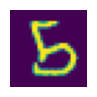

Prediction set: [5, 6, 8] | True class: 5
------------------------------


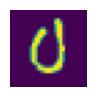

Prediction set: [0, 4] | True class: 0
------------------------------


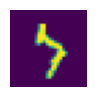

Prediction set: [3, 4, 5, 6, 7, 9] | True class: 7
------------------------------


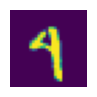

Prediction set: [4, 9] | True class: 4
------------------------------


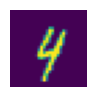

Prediction set: [4, 9] | True class: 4
------------------------------


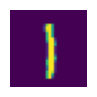

Prediction set: [1, 7] | True class: 1
------------------------------


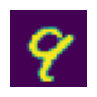

Prediction set: [8, 9] | True class: 9
------------------------------


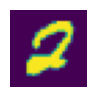

Prediction set: [2, 8] | True class: 2
------------------------------


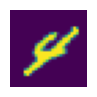

Prediction set: [4, 8] | True class: 4
------------------------------


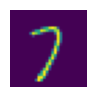

Prediction set: [3, 7] | True class: 7
------------------------------


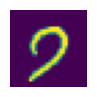

Prediction set: [0, 7, 9] | True class: 7
------------------------------


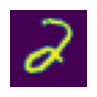

Prediction set: [2, 8] | True class: 2
------------------------------


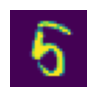

Prediction set: [5, 6] | True class: 5
------------------------------


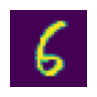

Prediction set: [6, 8] | True class: 6
------------------------------


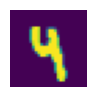

Prediction set: [4, 9] | True class: 4
------------------------------


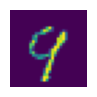

Prediction set: [4, 7, 8, 9] | True class: 9
------------------------------


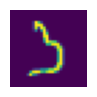

Prediction set: [3, 5, 9] | True class: 3
------------------------------


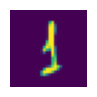

Prediction set: [1, 3] | True class: 1
------------------------------


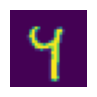

Prediction set: [4, 9] | True class: 4
------------------------------


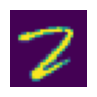

Prediction set: [2, 7] | True class: 2
------------------------------


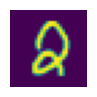

Prediction set: [2, 8] | True class: 2
------------------------------


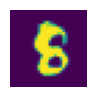

Prediction set: [6, 8] | True class: 8
------------------------------


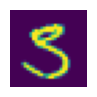

Prediction set: [3, 5, 8] | True class: 3
------------------------------


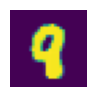

Prediction set: [8, 9] | True class: 8
------------------------------


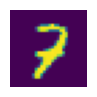

Prediction set: [3, 7] | True class: 7
------------------------------


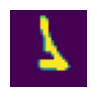

Prediction set: [1, 8] | True class: 1
------------------------------


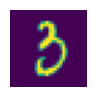

Prediction set: [2, 3] | True class: 3
------------------------------


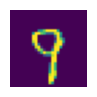

Prediction set: [8, 9] | True class: 9
------------------------------


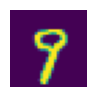

Prediction set: [8, 9] | True class: 9
------------------------------


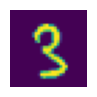

Prediction set: [3, 8] | True class: 3
------------------------------


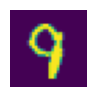

Prediction set: [8, 9] | True class: 9
------------------------------


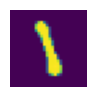

Prediction set: [1, 8] | True class: 1
------------------------------


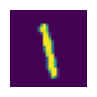

Prediction set: [1, 7, 8] | True class: 1
------------------------------


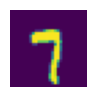

Prediction set: [7, 9] | True class: 7
------------------------------


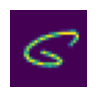

Prediction set: [0, 5, 8] | True class: 6
------------------------------


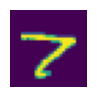

Prediction set: [2, 7] | True class: 7
------------------------------


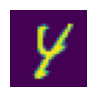

Prediction set: [4, 8] | True class: 4
------------------------------


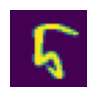

Prediction set: [5, 6, 8] | True class: 5
------------------------------


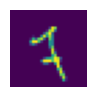

Prediction set: [1, 2, 3, 4, 7, 8, 9] | True class: 7
------------------------------


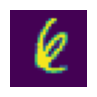

Prediction set: [6, 8] | True class: 6
------------------------------


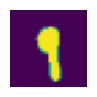

Prediction set: [8, 9] | True class: 9
------------------------------


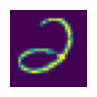

Prediction set: [2, 3] | True class: 2
------------------------------


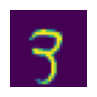

Prediction set: [3, 8] | True class: 3
------------------------------


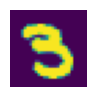

Prediction set: [3, 5] | True class: 3
------------------------------


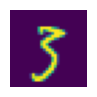

Prediction set: [3, 5] | True class: 3
------------------------------


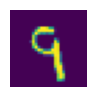

Prediction set: [8, 9] | True class: 9
------------------------------


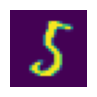

Prediction set: [3, 5, 8] | True class: 5
------------------------------


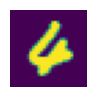

Prediction set: [4, 6] | True class: 4
------------------------------


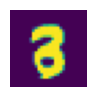

Prediction set: [2, 3, 8] | True class: 3
------------------------------


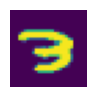

Prediction set: [3, 7] | True class: 3
------------------------------


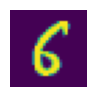

Prediction set: [6, 8] | True class: 6
------------------------------


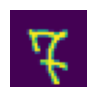

Prediction set: [7, 8] | True class: 7
------------------------------


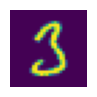

Prediction set: [3, 8] | True class: 3
------------------------------


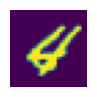

Prediction set: [0, 4, 8] | True class: 4
------------------------------


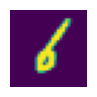

Prediction set: [1, 6, 8] | True class: 6
------------------------------


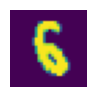

Prediction set: [5, 6, 8] | True class: 6
------------------------------


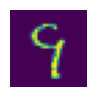

Prediction set: [8, 9] | True class: 9
------------------------------


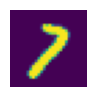

Prediction set: [3, 7] | True class: 7
------------------------------


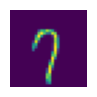

Prediction set: [7, 9] | True class: 7
------------------------------


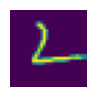

Prediction set: [2, 4] | True class: 2
------------------------------


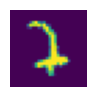

Prediction set: [1, 2, 3, 7] | True class: 7
------------------------------


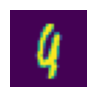

Prediction set: [4, 5, 6, 9] | True class: 9
------------------------------


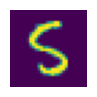

Prediction set: [5, 8] | True class: 5
------------------------------


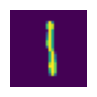

Prediction set: [1, 7, 8] | True class: 1
------------------------------


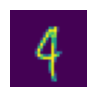

Prediction set: [4, 8, 9] | True class: 4
------------------------------


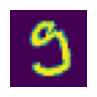

Prediction set: [5, 9] | True class: 9
------------------------------


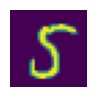

Prediction set: [5, 8] | True class: 5
------------------------------


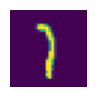

Prediction set: [1, 7, 8, 9] | True class: 7
------------------------------


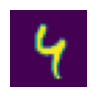

Prediction set: [4, 9] | True class: 4
------------------------------


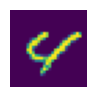

Prediction set: [4, 8] | True class: 4
------------------------------


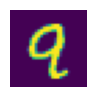

Prediction set: [8, 9] | True class: 9
------------------------------


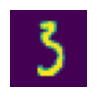

Prediction set: [3, 8] | True class: 3
------------------------------


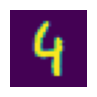

Prediction set: [4, 9] | True class: 4
------------------------------


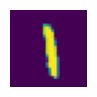

Prediction set: [1, 7, 8] | True class: 1
------------------------------


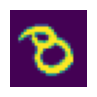

Prediction set: [0, 8, 9] | True class: 8
------------------------------


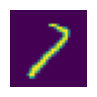

Prediction set: [2, 3, 7, 8, 9] | True class: 7
------------------------------


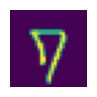

Prediction set: [0, 5, 7, 8, 9] | True class: 7
------------------------------


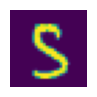

Prediction set: [3, 5, 8] | True class: 5
------------------------------


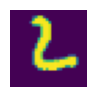

Prediction set: [2, 6] | True class: 2
------------------------------


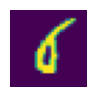

Prediction set: [5, 6] | True class: 6
------------------------------


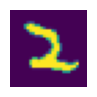

Prediction set: [2, 7] | True class: 2
------------------------------


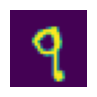

Prediction set: [8, 9] | True class: 9
------------------------------


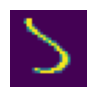

Prediction set: [3, 5] | True class: 5
------------------------------


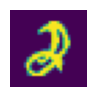

Prediction set: [2, 3, 8] | True class: 2
------------------------------


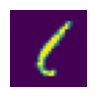

Prediction set: [1, 6, 8] | True class: 1
------------------------------


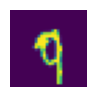

Prediction set: [0, 3, 4, 5, 7, 8, 9] | True class: 9
------------------------------


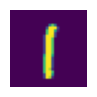

Prediction set: [1, 8] | True class: 1
------------------------------


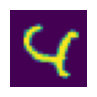

Prediction set: [4, 8] | True class: 4
------------------------------


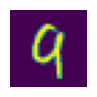

Prediction set: [4, 9] | True class: 9
------------------------------


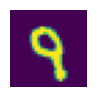

Prediction set: [8, 9] | True class: 9
------------------------------


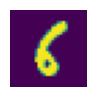

Prediction set: [6, 8] | True class: 6
------------------------------


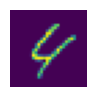

Prediction set: [4, 8] | True class: 4
------------------------------


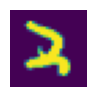

Prediction set: [2, 3, 7] | True class: 2
------------------------------


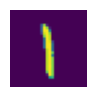

Prediction set: [1, 7, 8] | True class: 1
------------------------------


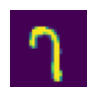

Prediction set: [7, 9] | True class: 7
------------------------------


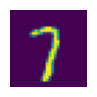

Prediction set: [3, 7] | True class: 7
------------------------------


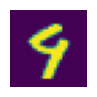

Prediction set: [8, 9] | True class: 9
------------------------------


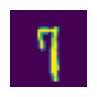

Prediction set: [4, 7, 8, 9] | True class: 7
------------------------------


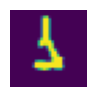

Prediction set: [1, 3, 5] | True class: 1
------------------------------


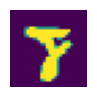

Prediction set: [7, 8] | True class: 8
------------------------------


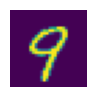

Prediction set: [8, 9] | True class: 9
------------------------------


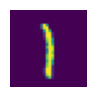

Prediction set: [1, 7] | True class: 1
------------------------------


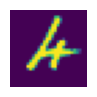

Prediction set: [2, 4, 6] | True class: 4
------------------------------


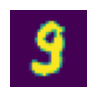

Prediction set: [8, 9] | True class: 9
------------------------------


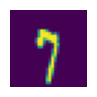

Prediction set: [7, 9] | True class: 7
------------------------------


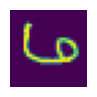

Prediction set: [4, 6] | True class: 6
------------------------------


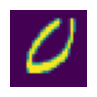

Prediction set: [0, 4] | True class: 0
------------------------------


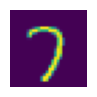

Prediction set: [3, 7] | True class: 7
------------------------------


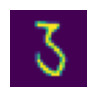

Prediction set: [3, 8] | True class: 3
------------------------------


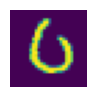

Prediction set: [0, 6] | True class: 0
------------------------------


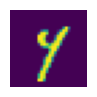

Prediction set: [4, 8, 9] | True class: 4
------------------------------


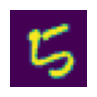

Prediction set: [5, 6, 8] | True class: 5
------------------------------


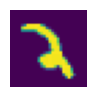

Prediction set: [2, 3, 7, 8] | True class: 2
------------------------------


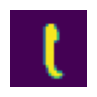

Prediction set: [1, 8] | True class: 1
------------------------------


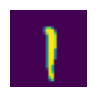

Prediction set: [1, 7, 9] | True class: 1
------------------------------


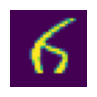

Prediction set: [6, 8] | True class: 6
------------------------------


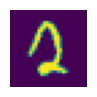

Prediction set: [0, 1, 2, 7] | True class: 2
------------------------------


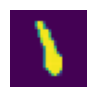

Prediction set: [1, 8] | True class: 1
------------------------------


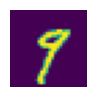

Prediction set: [8, 9] | True class: 9
------------------------------


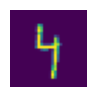

Prediction set: [4, 9] | True class: 4
------------------------------


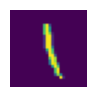

Prediction set: [1, 8] | True class: 1
------------------------------


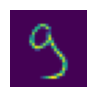

Prediction set: [3, 5, 8, 9] | True class: 9
------------------------------


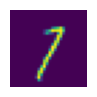

Prediction set: [1, 7] | True class: 7
------------------------------


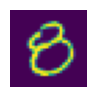

Prediction set: [0, 8] | True class: 8
------------------------------


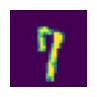

Prediction set: [7, 9] | True class: 7
------------------------------


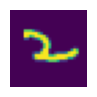

Prediction set: [2, 7] | True class: 2
------------------------------


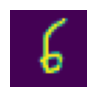

Prediction set: [6, 8] | True class: 6
------------------------------


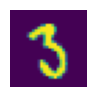

Prediction set: [3, 8] | True class: 3
------------------------------


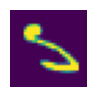

Prediction set: [3, 5, 6, 8] | True class: 5
------------------------------


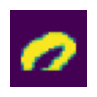

Prediction set: [0, 7, 9] | True class: 0
------------------------------


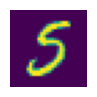

Prediction set: [5, 9] | True class: 5
------------------------------


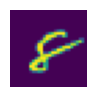

Prediction set: [5, 8] | True class: 8
------------------------------


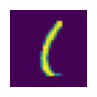

Prediction set: [1, 6] | True class: 1
------------------------------


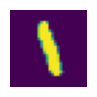

Prediction set: [1, 8] | True class: 1
------------------------------


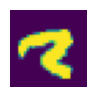

Prediction set: [0, 1, 2, 3, 7, 8] | True class: 2
------------------------------


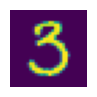

Prediction set: [3, 5] | True class: 3
------------------------------


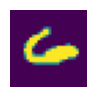

Prediction set: [4, 6] | True class: 6
------------------------------


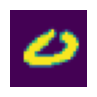

Prediction set: [0, 4, 9] | True class: 0
------------------------------


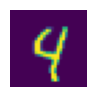

Prediction set: [4, 9] | True class: 4
------------------------------


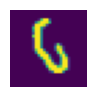

Prediction set: [5, 6] | True class: 6
------------------------------


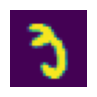

Prediction set: [0, 2, 3, 7] | True class: 3
------------------------------


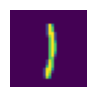

Prediction set: [1, 7] | True class: 1
------------------------------


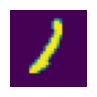

Prediction set: [1, 2] | True class: 1
------------------------------


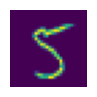

Prediction set: [5, 8] | True class: 5
------------------------------


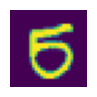

Prediction set: [5, 6, 8] | True class: 5
------------------------------


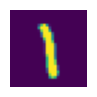

Prediction set: [1, 7, 8] | True class: 1
------------------------------


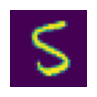

Prediction set: [5, 8] | True class: 5
------------------------------


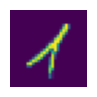

Prediction set: [1, 4] | True class: 1
------------------------------
Test Accuracy on non-abstained examples: 100.00%
Test Coverage (proportion of non-abstained examples): 86.62%


In [4]:
n_printed = 0
n_printed_max = 250
correct, total = 0, 0
n_covered = 0
with torch.inference_mode():
    for batch_idx, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)

        # For each possible class, compute what the nonconformity score would be
        # if that class were the true class
        all_class_scores = []
        for c in range(10):  # 10 classes for MNIST
            # Create a hypothetical label tensor with all elements set to class c
            hypothetical_y = torch.full_like(y, c)
            # Compute the probability for this hypothetical class
            class_prob = probs.gather(1, hypothetical_y.view(-1, 1))
            # Compute nonconformity score: 1 - p(y)
            nonconformity_score = 1 - class_prob
            all_class_scores.append(nonconformity_score.item())

        # The prediction set includes all classes with nonconformity scores <= threshold
        prediction_set = [c for c, score in enumerate(all_class_scores) if score <= calibration_threshold]

        # Only display examples with multiple classes in the prediction set
        if len(prediction_set) > 1:
            graph.figure(figsize=(1, 1))
            graph.imshow(x.squeeze().cpu().numpy(), cmap='viridis')
            graph.grid(False)
            graph.axis('off')
            graph.show()
            print(f'Prediction set: {prediction_set} | True class: {y.item()}')
            print('-'*30)
            n_printed += 1
        else:
            # Track accuracy to simulate abstention
            # predicted is not defined - we should use prediction_set
            correct += (y.item() in prediction_set)
            n_covered += 1
            total += 1
        if n_printed >= n_printed_max:
            break

print(f'Test Accuracy on non-abstained examples: {correct / total:.2%}')
print(f'Test Coverage (proportion of non-abstained examples): {n_covered / (batch_idx+1):.2%}')